In [2]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)
viscosity = .01/pi

# Define initial condition
def fun_u_0(x):
    return -tf.sin(pi * x)

# Define boundary condition
def fun_u_b(t, x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

# Define residual of the PDE
def fun_r(t, x, u, u_t, u_x, u_xx):
    return u_t + u * u_x - viscosity * u_xx

In [3]:
N_0 = 50
N_b = 50
N_r = 10000

# Specify boundaries
lb = tf.constant([0., -1.], dtype=DTYPE)
ub = tf.constant([1., 1.], dtype=DTYPE)

def Eikonal_u_0(x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

def Eikonal_u_b(t, x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

In [4]:

# Set random seed for reproducible results
tf.random.set_seed(0)

# Final time data
t_0 = tf.ones((N_0,1), dtype=DTYPE) * ub[0]
x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([t_0, x_0], axis=1)
u_0 = Eikonal_u_0(x_0)

# Boundary data
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b = tf.concat([t_b, x_b], axis=1)
u_b = Eikonal_u_b(t_b, x_b)

# Collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

# Collect boundary and inital data in lists
X_data = [X_0,X_b]
u_data = [u_0,u_b]

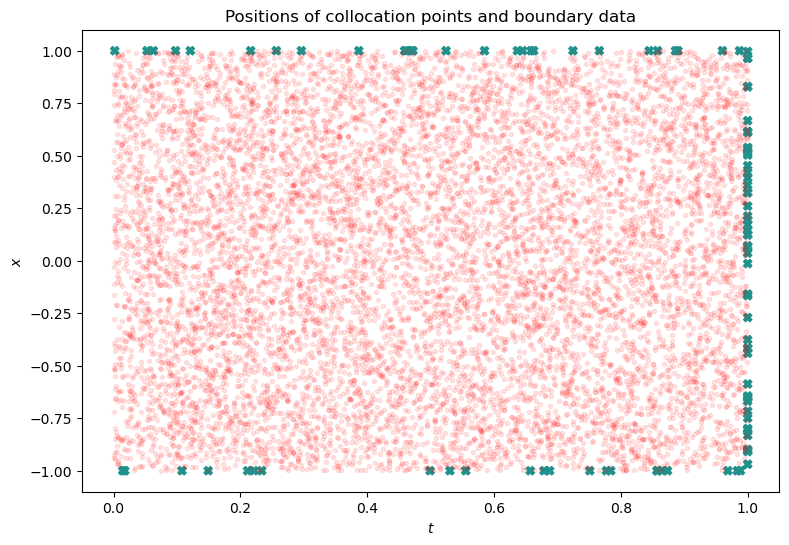

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
plt.scatter(t_0, x_0, c=u_0, marker='X', vmin=-1, vmax=1)
plt.scatter(t_b, x_b, c=u_b, marker='X', vmin=-1, vmax=1)
plt.scatter(t_r, x_r, c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data');
#plt.savefig('Xdata_Burgers.pdf', bbox_inches='tight', dpi=300)

In [6]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))
    
    return model

In [7]:
class EikonalPINNSolver(PINNSolver):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def fun_r(self, t, x, u, u_t, u_x, u_xx):
        """Residual of the PDE"""
        return -u_t + tf.abs(u_x) - 1.
    
    def get_r(self):
        """We update get_r since the Eikonal equation is a first-order equation.
        Therefore, it is not necessary to compute second derivatives."""
        
        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(self.t)
            tape.watch(self.x)
            
            # Compute current values u(t,x)
            u = self.model(tf.stack([self.t[:,0], self.x[:,0]], axis=1))
            
        u_x = tape.gradient(u, self.x)
            
        u_t = tape.gradient(u, self.t)
        
        del tape
        
        return self.fun_r(self.t, self.x, u, u_t, u_x, None)

NameError: name 'PINNSolver' is not defined